In [ ]:
# %%writefile ../util/visualizer.py

import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, 
    recall_score, precision_score, f1_score, accuracy_score,
    PrecisionRecallDisplay, average_precision_score, precision_recall_curve,
    RocCurveDisplay, roc_auc_score, roc_curve, mean_squared_error, mean_absolute_error, r2_score
)

__version__ = 1.1

######################################
# 📊 모델 평가 지표 시각화 함수
######################################

def plot_confusion_matrix(y_true, y_pred, title=None):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap="Blues")
    ax.set_title(title or "Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.tight_layout()
    plt.show()
    return fig

def plot_roc_curve(y_true, y_scores, estimator_name=None, title=None):
    auc_score = roc_auc_score(y_true, y_scores)
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    fig, ax = plt.subplots()
    disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_score, estimator_name=estimator_name)
    disp.plot(ax=ax)
    ax.set_title(title or "ROC Curve")
    plt.tight_layout()
    plt.show()
    return fig

def plot_precision_recall_curve(y_true, y_scores, estimator_name=None, title=None):
    ap = average_precision_score(y_true, y_scores)
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    fig, ax = plt.subplots()
    disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=ap, estimator_name=estimator_name)
    disp.plot(ax=ax)
    ax.set_title(title or "Precision-Recall Curve")
    plt.tight_layout()
    plt.show()
    return fig


def plot_predicted_vs_actual(y_true, y_pred, title="Predicted vs Actual"):
    """
    실제값과 예측값을 비교하는 산점도 그래프를 출력합니다.
    예측값이 정확할수록 점들이 대각선(45도 기준선)을 따라 분포하게 됩니다.

    Parameters:
    - y_true: 실제 값 배열
    - y_pred: 예측 값 배열
    - title: 그래프 제목

    Returns:
    - fig: matplotlib figure 객체 (streamlit에서 사용 가능)
    """
    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, alpha=0.6)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # 45도 기준선
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()
    return fig

def plot_residuals(y_true, y_pred, title="Residual Plot"):
    """
    잔차(residual = 실제값 - 예측값)를 시각화하여 
    예측 모델이 편향(bias)되어 있는지 확인합니다.
    이상적으로는 잔차들이 0을 중심으로 고르게 분포해야 합니다.

    Parameters:
    - y_true: 실제 값 배열
    - y_pred: 예측 값 배열
    - title: 그래프 제목

    Returns:
    - fig: matplotlib figure 객체
    """
    residuals = y_true - y_pred
    fig, ax = plt.subplots()
    ax.scatter(y_pred, residuals, alpha=0.6)
    ax.axhline(0, color='red', linestyle='--')  # 기준선
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Residuals")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()
    return fig

def plot_prediction_histogram(y_true, y_pred, title="Prediction Distribution"):
    """
    실제값과 예측값의 분포를 히스토그램 + KDE(밀도곡선) 형태로 비교합니다.
    두 분포가 비슷할수록 모델이 잘 예측하고 있는 것입니다.

    Parameters:
    - y_true: 실제 값 배열
    - y_pred: 예측 값 배열
    - title: 그래프 제목

    Returns:
    - fig: matplotlib figure 객체
    """
    fig, ax = plt.subplots()
    sns.histplot(y_true, color='blue', label='Actual', kde=True, stat="density", ax=ax)
    sns.histplot(y_pred, color='orange', label='Predicted', kde=True, stat="density", ax=ax)
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()
    return fig

def regression_metrics_table(y_true, y_pred):
    """
    회귀 평가 지표들을 계산하여 dict로 반환합니다.
    Streamlit에서는 st.table() 등으로 출력 가능.

    포함된 지표:
    - MAE: 평균 절대 오차 (Mean Absolute Error)
    - MSE: 평균 제곱 오차 (Mean Squared Error)
    - RMSE: 평균 제곱근 오차 (Root MSE)
    - R2 Score: 결정 계수 (설명력)

    Parameters:
    - y_true: 실제 값 배열
    - y_pred: 예측 값 배열

    Returns:
    - dict: 각 지표들의 명칭과 값
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {
        "MAE": round(mae, 4),
        "MSE": round(mse, 4),
        "RMSE": round(rmse, 4),
        "R2 Score": round(r2, 4)
    }


######################################
# 📈 EDA 시각화 함수
######################################

def plot_boxplot_by_target(df, target_col='target', numeric_cols=None, title_prefix="Box Plot by", color_palette='Set2'):
    """
    target 값(이진 분류)에 따라 그룹화된 boxplot을 컬럼별로 시각화

    Parameters:
    - df: DataFrame
    - target_col: str - 타겟 컬럼명 (예: 'target' 또는 'churn')
    - numeric_cols: list[str] - 수치형 컬럼 리스트 (기본값: 수치형 자동 선택)
    - title_prefix: str - 그래프 제목 앞부분
    - color_palette: str - seaborn color palette (기본값: Set2)
    """
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.drop(target_col).tolist()

    for col in numeric_cols:
        plt.figure(figsize=(6, 4))
        sns.boxplot(data=df, x=target_col, y=col, palette=color_palette, showmeans=True,
                    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"})
        plt.title(f"{title_prefix} '{col}' by {target_col}", fontsize=13)
        plt.xlabel(target_col)
        plt.ylabel(col)
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    #plt.savefig("my_plot.png")


# numeric_cols 리스트에 따라 상관계수 히트맵을 시각화
def plot_correlation_heatmap(df, numeric_cols, target_col="target", title="히트맵 시각화를 통한 컬럼별 상관관계 확인", annot=True, cmap='coolwarm', figsize=(12, 10)):
    """
    numeric_cols 리스트에 따라 상관계수 히트맵을 시각화
    """
    corr = df[numeric_cols + [target_col]].corr()
    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=annot, fmt=".4f", cmap=cmap, linewidths=0.5, vmin=-1, vmax=1, cbar_kws={"label": "Correlation"})
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

#  여러 컬럼에 대해 이탈자(target=1) 분포를 그룹별로 시각화
def plot_churn_distribution_by_columns(df, columns, target_col='target', ncols=3, figsize=(18, 4)):
    """
    여러 컬럼에 대해 이탈자(target=1) 분포를 그룹별로 시각화

    Parameters:
    - df: DataFrame
    - columns: list[str] - 분석할 컬럼 리스트
    - target_col: str - 타겟 변수명 (기본값: 'target')
    - ncols: int - 한 행당 subplot 개수
    - figsize: tuple - 전체 그래프 크기
    """
    n_plots = len(columns)
    nrows = math.ceil(n_plots / ncols)

    plt.figure(figsize=(figsize[0], figsize[1] * nrows))

    for idx, col in enumerate(columns):
        plt.subplot(nrows, ncols, idx + 1)
        sns.histplot(data=df, x=col, hue=target_col, multiple='stack', shrink=0.9, palette='coolwarm', bins=30)
        plt.title(f'{col} vs {target_col}', fontsize=10)
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

######################################
# 🧪 테스트 코드
######################################

# if __name__ == "__main__":
#     from sklearn.datasets import make_classification
#     from sklearn.model_selection import train_test_split
#     from sklearn.linear_model import LogisticRegression

#     X, y = make_classification(n_samples=500, n_features=5, n_informative=3, random_state=42)
#     df = pd.DataFrame(X, columns=['score_mean', 'click_sum', 'click_mean', 'dummy1', 'dummy2'])
#     df['target'] = y
#     df['gender'] = np.random.choice(['M', 'F'], size=500)
#     df['highest_education'] = np.random.choice(['HE', 'A Level', 'No Formal'], size=500)
#     df['final_result'] = np.random.choice(['Pass', 'Distinction', 'Fail', 'Withdrawn'], size=500)

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#     model = LogisticRegression()
#     model.fit(X_train, y_train)
#     y_proba = model.predict_proba(X_test)[:, 1]
#     y_pred = model.predict(X_test)

#     # 모델 평가 지표 시각화
#     plot_precision_recall_curve(y_test, y_proba)
#     plot_roc_curve(y_test, y_proba)
#     plot_confusion_matrix(y_test, y_pred)

#     # 데이터 EDA 시각화
#     plot_final_result_distribution(df)
#     plot_feature_vs_target(df, 'score_mean')
#     plot_categorical_target_rate(df, 'gender')
#     plot_boxplot(df, ['score_mean', 'click_sum'])
#     plot_churn_rate_by_category(df, 'target', ['gender', 'highest_education'])
#     plot_correlation_heatmap(df)


Overwriting ../util/visualizer.py


In [54]:
# dataset load
data_path = '../data/merged__target_dataset_ver1.1.csv'
df = pd.read_csv(data_path)
# df.info()

categorical_columns = ['code_module','code_presentation','id_student','gender','region','highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts', 'disability', 'is_dropout']
numeric_columns = ['studied_credits', 'date_registration', 'date_unregistration', 'sum_click', 'avg_score', 'banked_ratio']
target = "target"  # index =17

categorical_columns_index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10,16]
numeric_columns_index = [9,11,12,13,14,15]

df.head()


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,date_registration,date_unregistration,sum_click,avg_score,banked_ratio,is_dropout,target
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,-159.0,NaN,934.0,82.0,0.0,0,0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,-53.0,NaN,1435.0,66.4,0.0,0,0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,-92.0,12.0,281.0,0.0,0.0,1,1
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,-52.0,NaN,2158.0,76.0,0.0,0,0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,-176.0,NaN,1034.0,54.4,0.0,0,0


C:\Users\Playdata\AppData\Local\Temp\ipykernel_18096\3554228447.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=target_col, y=col, palette=color_palette, showmeans=True,


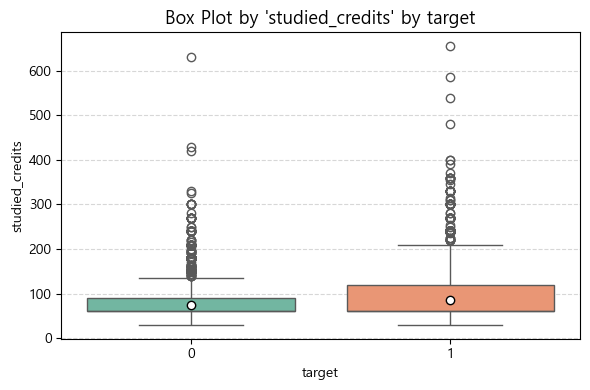

C:\Users\Playdata\AppData\Local\Temp\ipykernel_18096\3554228447.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=target_col, y=col, palette=color_palette, showmeans=True,
C:\Users\Playdata\AppData\Local\Temp\ipykernel_18096\3554228447.py:73: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
c:\Users\Playdata\AppData\Local\miniconda3\envs\2nd\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


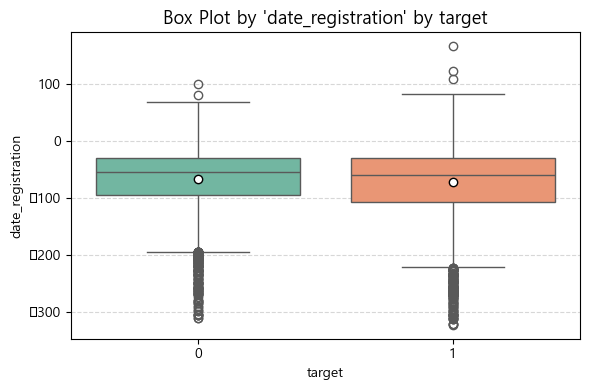

C:\Users\Playdata\AppData\Local\Temp\ipykernel_18096\3554228447.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=target_col, y=col, palette=color_palette, showmeans=True,
C:\Users\Playdata\AppData\Local\Temp\ipykernel_18096\3554228447.py:73: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
c:\Users\Playdata\AppData\Local\miniconda3\envs\2nd\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


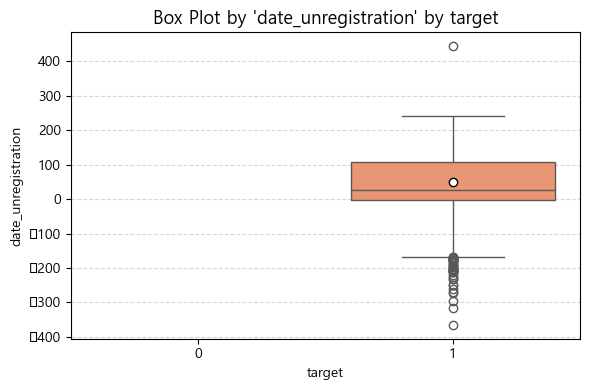

C:\Users\Playdata\AppData\Local\Temp\ipykernel_18096\3554228447.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=target_col, y=col, palette=color_palette, showmeans=True,


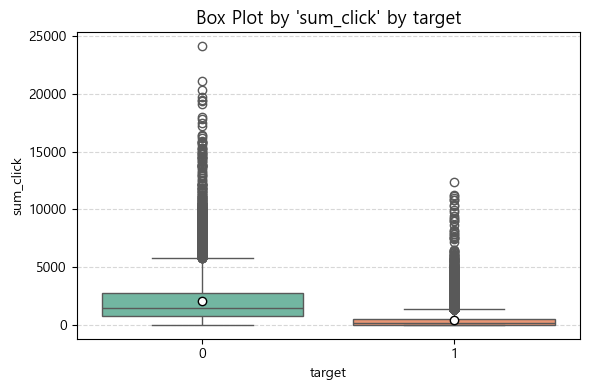

C:\Users\Playdata\AppData\Local\Temp\ipykernel_18096\3554228447.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=target_col, y=col, palette=color_palette, showmeans=True,


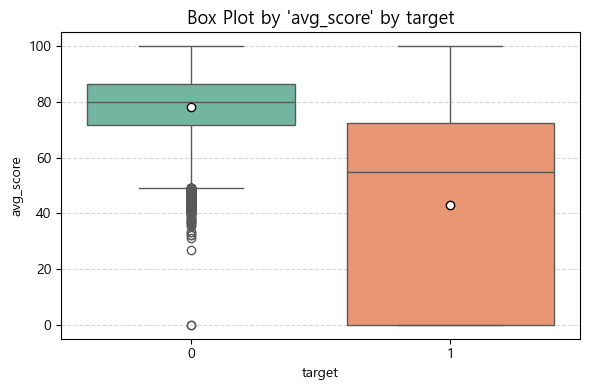

C:\Users\Playdata\AppData\Local\Temp\ipykernel_18096\3554228447.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=target_col, y=col, palette=color_palette, showmeans=True,


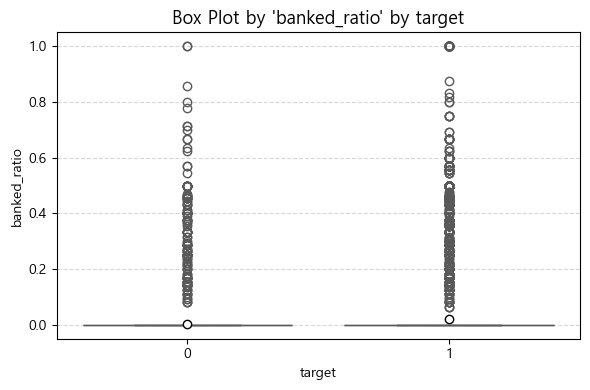

c:\Users\Playdata\AppData\Local\miniconda3\envs\2nd\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
c:\Users\Playdata\AppData\Local\miniconda3\envs\2nd\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


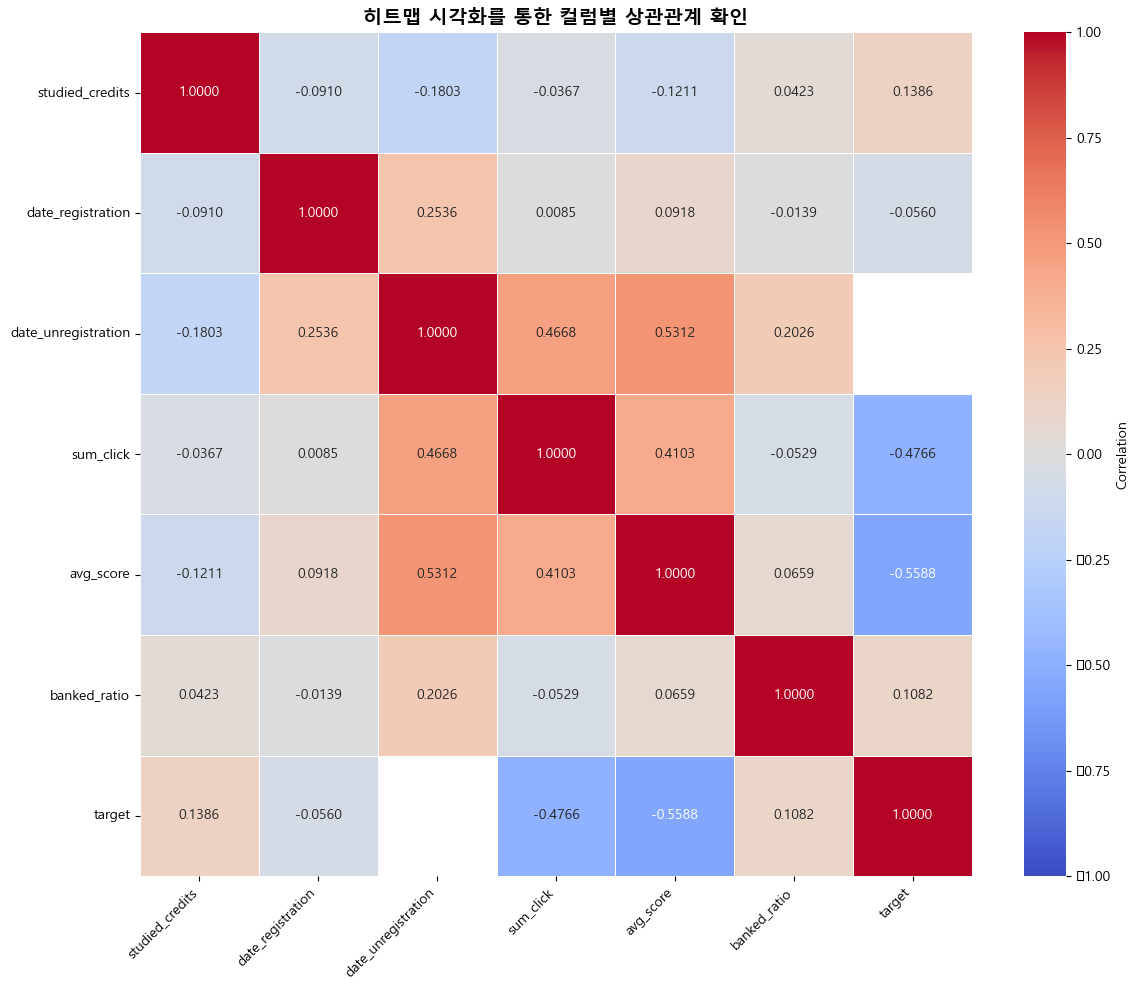

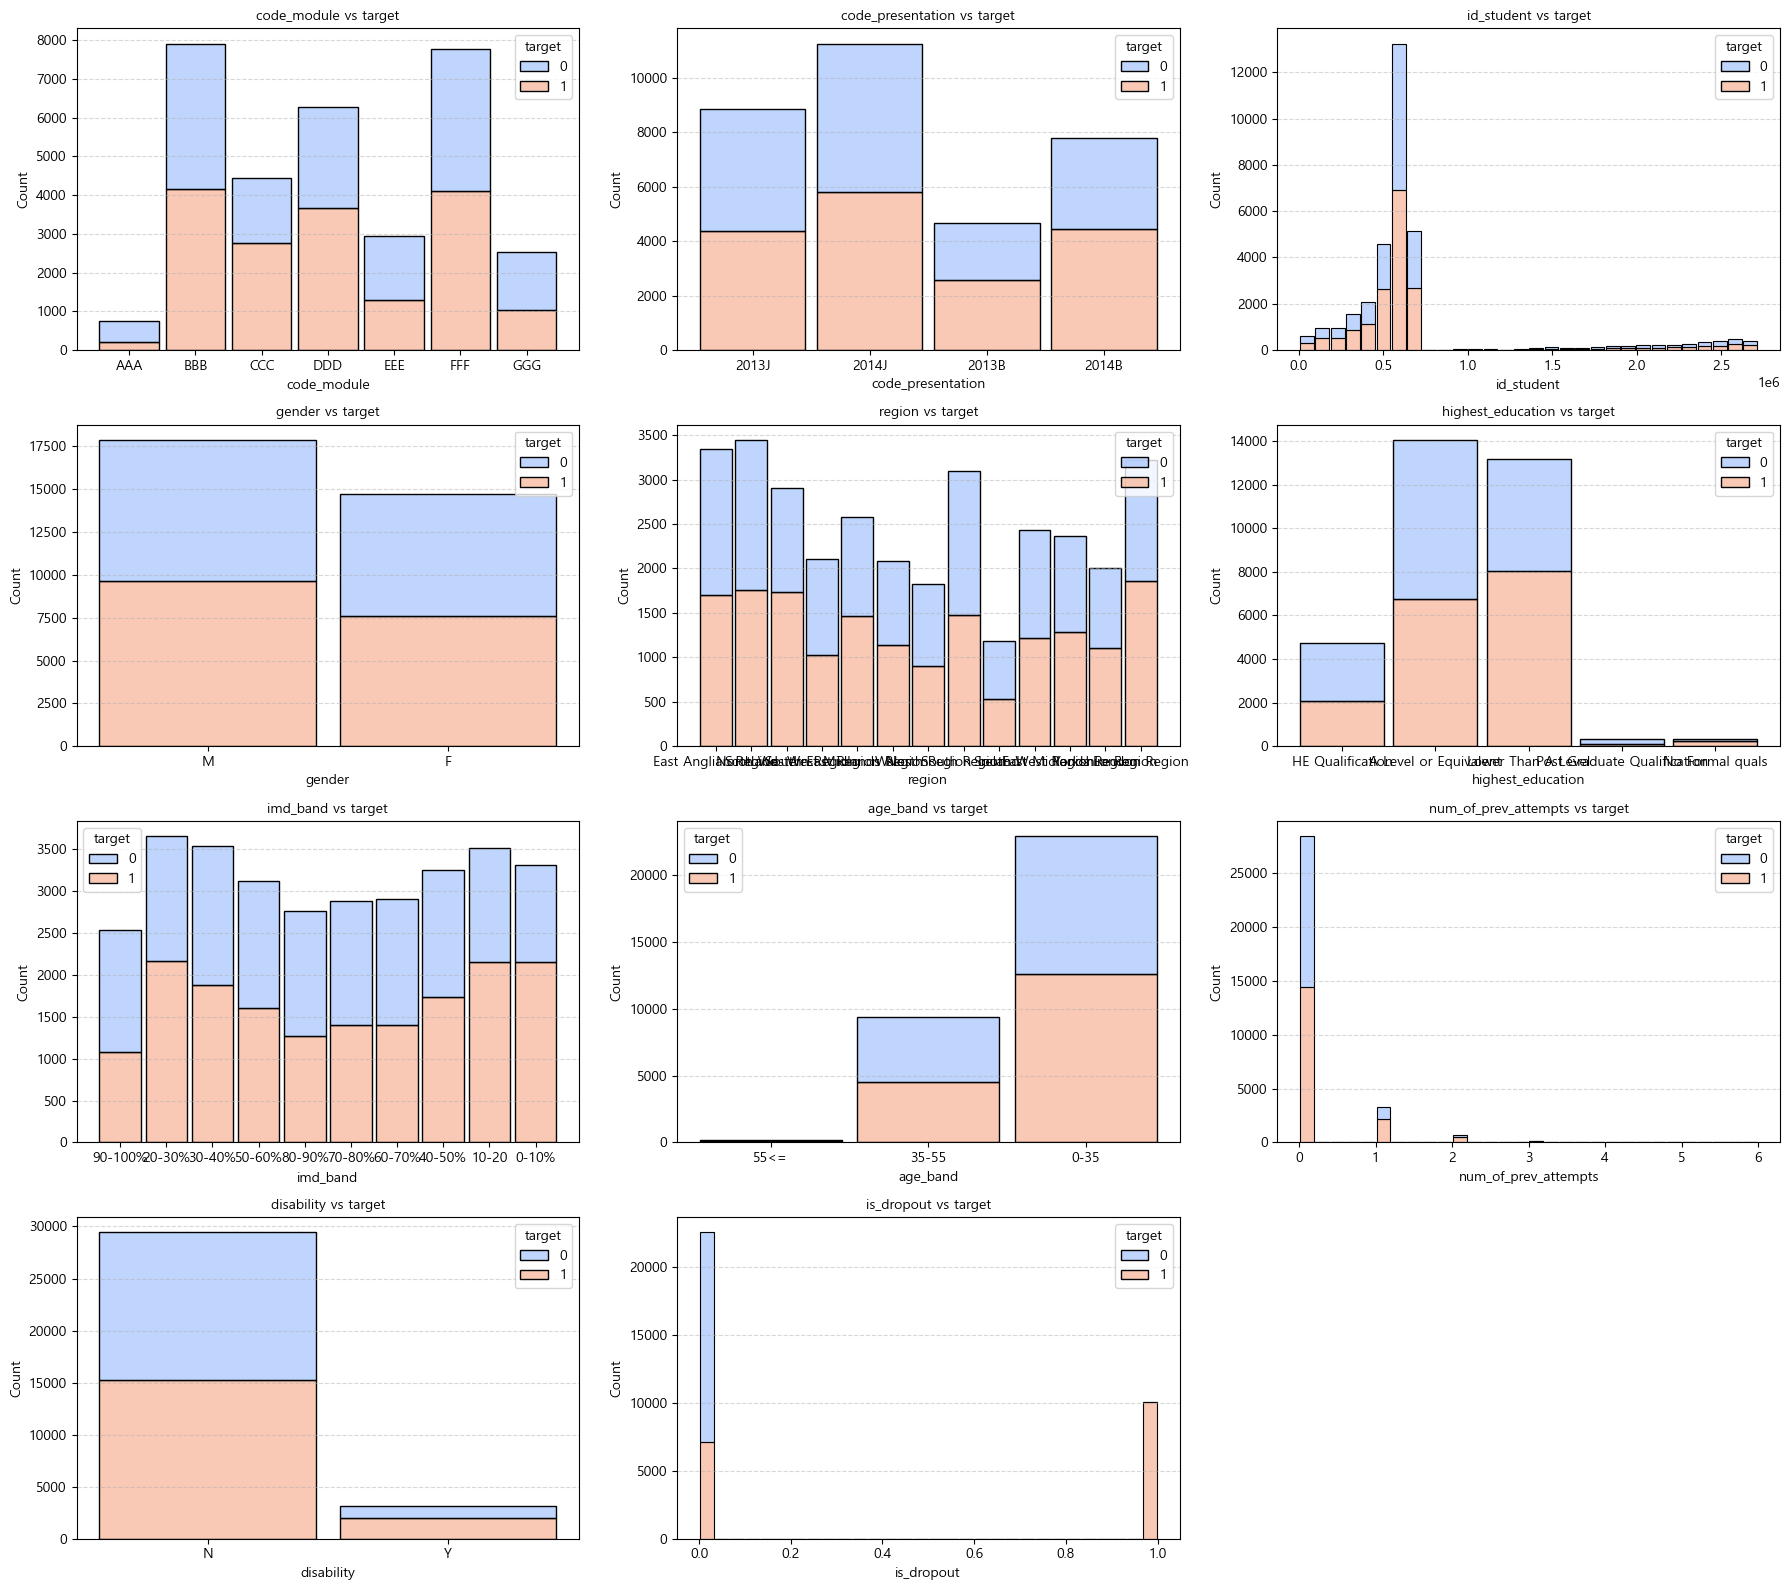

In [60]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'malgun gothic'


plot_boxplot_by_target(df,cols=numeric_columns, target_col=target, title_prefix="Box Plot by", color_palette='Set2')
plot_correlation_heatmap(df,numeric_cols=numeric_columns)
plot_churn_distribution_by_columns(df, columns=categorical_columns, target_col=target, ncols=3, figsize=(18, 4))